<a href="https://colab.research.google.com/github/varun-beep/AdvDataAnalytics_Lab/blob/main/2448555_Varun_TimeSeriesLab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADA Lab 1 - Varun
# Task 1: Fetch real-world time series data (Stock Prices with yfinance)


In [3]:
!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
import numpy as np

In [31]:
#daily stock data from Yahoo Finance
data = yf.download('TATAMOTORS.NS', start='2020-01-01', end='2023-12-31')

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS
Date,,,,,
2020-01-01,181.748581,183.965628,180.911039,182.438326,25968357
2020-01-02,190.912384,191.848468,181.896399,182.290534,57289863
2020-01-03,188.301193,192.784543,186.478282,190.074819,47572728
2020-01-06,182.931000,188.202651,182.339796,188.202651,28621212
2020-01-07,181.994904,186.626065,179.630060,184.261221,34995035


In [5]:
#only 'Close' price for time series analysis
stock_df = data[['Close']].copy()
stock_df.rename(columns={'Close': 'price'}, inplace=True)
stock_df.head()

Price,price
Ticker,TATAMOTORS.NS
Date,
2020-01-01,181.748581
2020-01-02,190.912384
2020-01-03,188.301193
2020-01-06,182.931000
2020-01-07,181.994904


Task 2: Preprocessing and Visualization

In [6]:
# Ensure index is in datetime format
stock_df.index = pd.to_datetime(stock_df.index)

# Check index type
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 992 entries, 2020-01-01 to 2023-12-29
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   (price, TATAMOTORS.NS)  992 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB


In [7]:
# Check for missing values
print("Missing values:\n", stock_df.isnull().sum())

# Fill or drop missing values
stock_df['price'].fillna(method='ffill', inplace=True)  # forward fill
stock_df.drop_duplicates(inplace=True)

Missing values:
 Price  Ticker       
price  TATAMOTORS.NS    0
dtype: int64


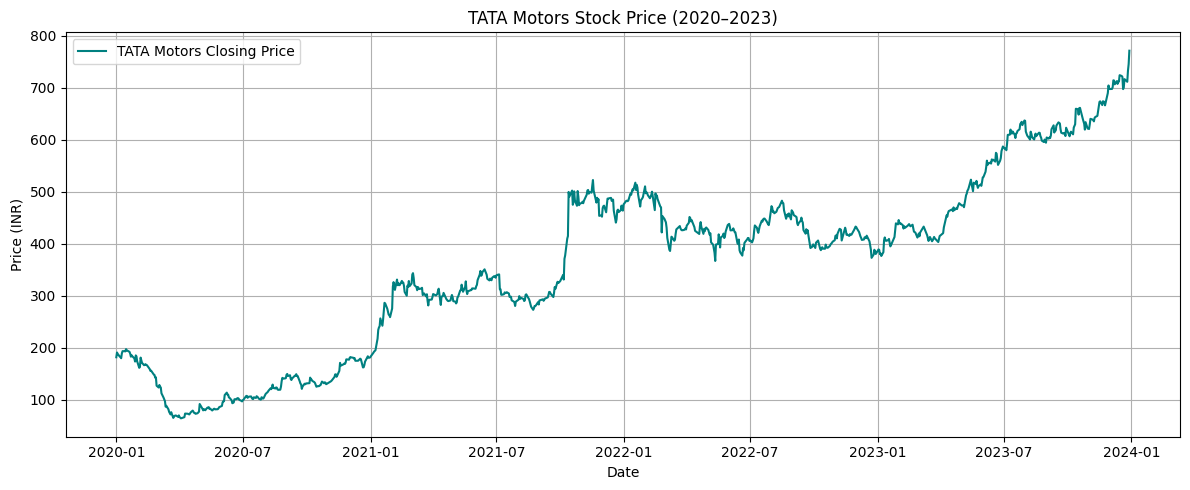

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(stock_df['price'], label='TATA Motors Closing Price', color='teal')
plt.title('TATA Motors Stock Price (2020–2023)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Task 3: Time Series Decomposition

This breaks your time series into:

Trend (long-term direction)
Seasonality (repeating patterns)
Residual (noise)

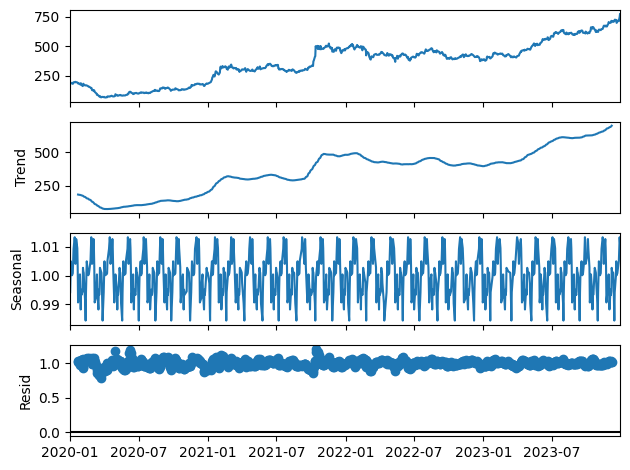

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(stock_df['price'], model='multiplicative', period=30)

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

Task 4: Stationarity Check

To use ARIMA/SARIMA, your time series must be stationary (constant mean & variance over time).

We’ll check in two ways:

📉 Rolling Mean & Variance Plot
📊 ADF Test (Augmented Dickey-Fuller)

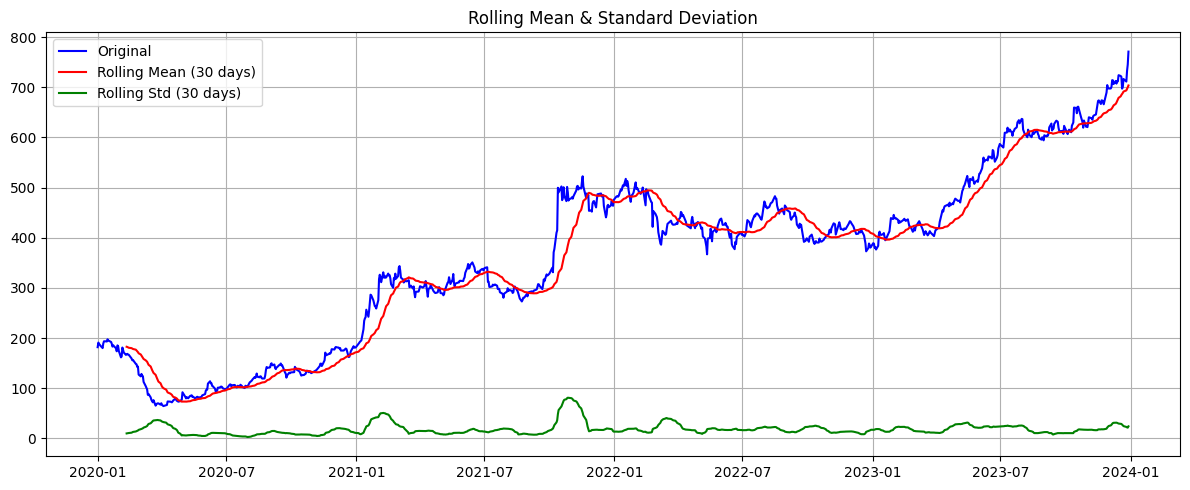

In [10]:
# Calculate rolling mean and std deviation
roll_mean = stock_df['price'].rolling(window=30).mean()
roll_std = stock_df['price'].rolling(window=30).std()

# Plot
plt.figure(figsize=(12,5))
plt.plot(stock_df['price'], label='Original', color='blue')
plt.plot(roll_mean, label='Rolling Mean (30 days)', color='red')
plt.plot(roll_std, label='Rolling Std (30 days)', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
adf_result = adfuller(stock_df['price'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: 0.5931351331993586
p-value: 0.9874451940760478
Critical Values:
   1%: -3.4373332444652944
   5%: -2.864622912101569
   10%: -2.568411524473161


As This dataset shows non-stationary, time series models (like ARIMA) assume stationarity so they can model consistent patterns.
If the data is non-stationary, the model might make wrong predictions

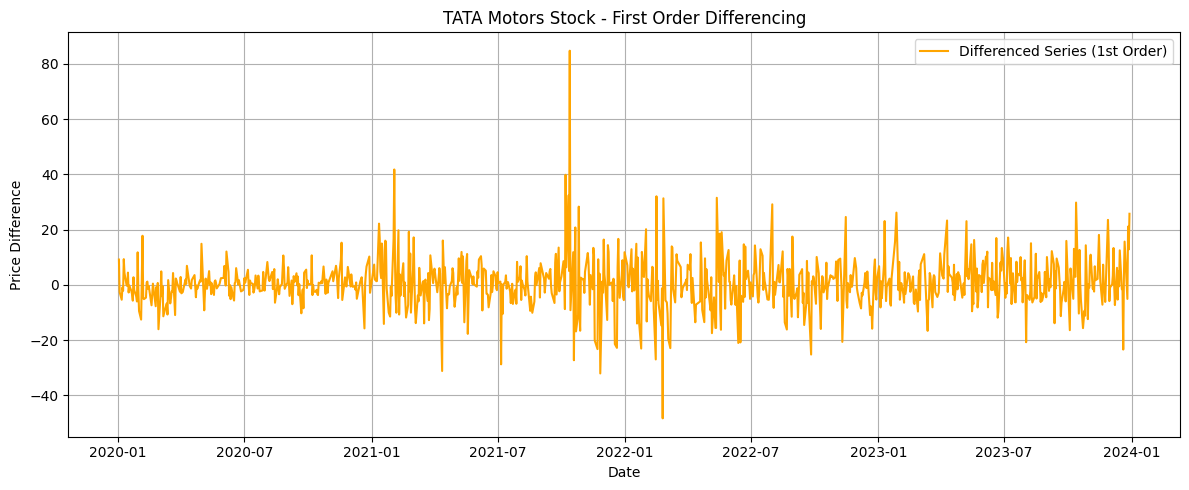

In [12]:
# Apply first order differencing
diff_data = stock_df['price'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 5))
plt.plot(diff_data, label='Differenced Series (1st Order)', color='orange')
plt.title('TATA Motors Stock - First Order Differencing')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# ADF test on differenced data
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(diff_data)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -30.76134830626909
p-value: 0.0
Critical Values:
   1%: -3.4373407098114765
   5%: -2.8646262040163566
   10%: -2.568413277899264


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Build the ARIMA model
model = ARIMA(stock_df['price'], order=(1, 1, 1))  # (p=1, d=1, q=1)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          TATAMOTORS.NS   No. Observations:                  940
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3399.714
Date:                Mon, 16 Jun 2025   AIC                           6805.428
Time:                        06:56:13   BIC                           6819.962
Sample:                             0   HQIC                          6810.969
                                - 940                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7180      0.304     -2.366      0.018      -1.313      -0.123
ma.L1          0.6928      0.318      2.179      0.029       0.070       1.316
sigma2        81.7165      1.651     49.494      0.0

Task 6: Forecast and Visualize Future Prices

In [19]:
print(forecast)
print(forecast_df.head())
print(forecast_df.tail())

940    770.204485
941    770.719859
942    770.349834
943    770.615502
944    770.424760
945    770.561708
946    770.463383
947    770.533978
948    770.483292
949    770.519683
950    770.493555
951    770.512314
952    770.498846
953    770.508516
954    770.501573
955    770.506558
956    770.502979
957    770.505549
958    770.503704
959    770.505028
960    770.504077
961    770.504760
962    770.504270
963    770.504622
964    770.504369
965    770.504550
966    770.504420
967    770.504514
968    770.504447
969    770.504495
Name: predicted_mean, dtype: float64
            Forecast
2023-12-30       NaN
2023-12-31       NaN
2024-01-01       NaN
2024-01-02       NaN
2024-01-03       NaN
            Forecast
2024-01-24       NaN
2024-01-25       NaN
2024-01-26       NaN
2024-01-27       NaN
2024-01-28       NaN


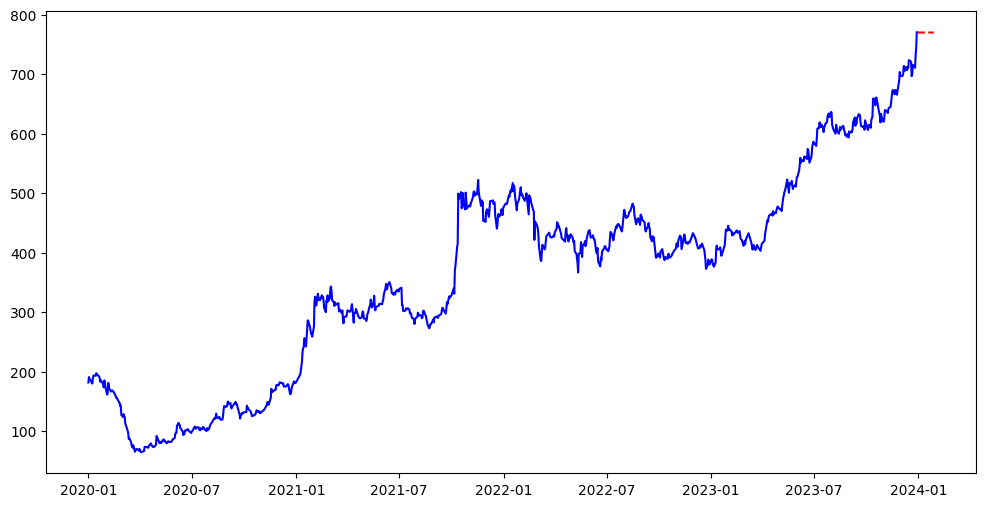

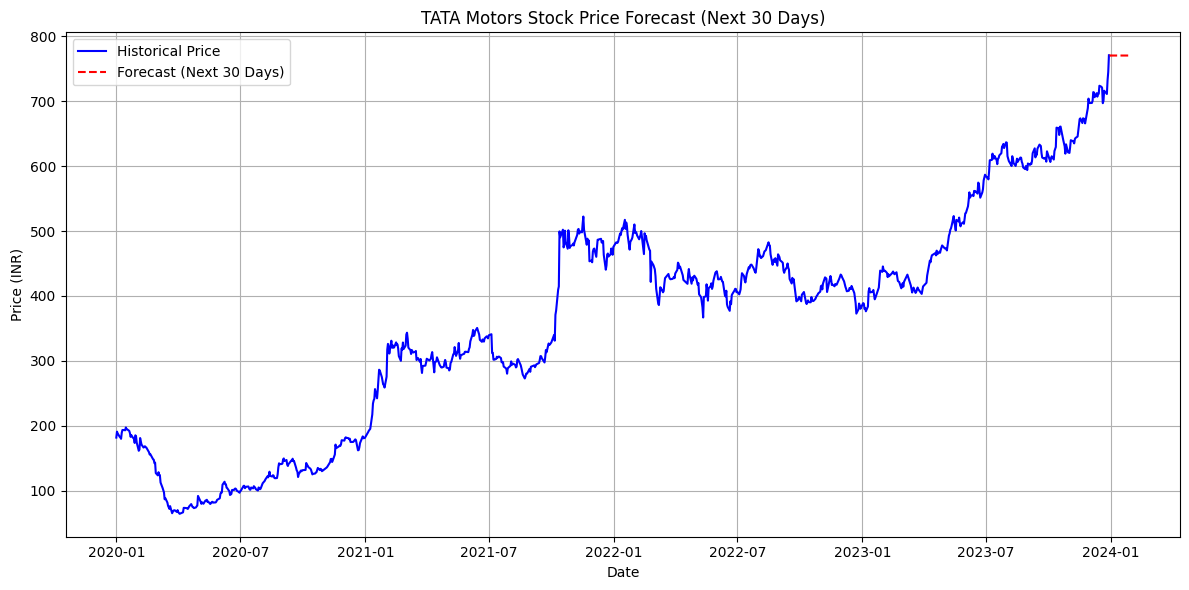

In [20]:
# 1. Ensure date column is datetime type and set as index
stock_df.index = pd.to_datetime(stock_df.index)
stock_df = stock_df.sort_index()

# 2. Forecast 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# 3. Generate proper forecast dates
last_date = stock_df.index[-1]
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# 4. Create forecast DataFrame
forecast_df = pd.DataFrame(forecast.values, index=forecast_dates, columns=['Forecast'])

# 5. Plot historical + forecasted values
plt.figure(figsize=(12,6))

# Plot historical data
plt.plot(stock_df.index, stock_df['price'], label='Historical Price', color='blue')

# Plot forecast data
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (Next 30 Days)', color='red', linestyle='dashed')

plt.figure(figsize=(12,6))
plt.plot(stock_df.index, stock_df['price'], label='Historical Price', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (Next 30 Days)', color='red', linestyle='dashed')
plt.title('TATA Motors Stock Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

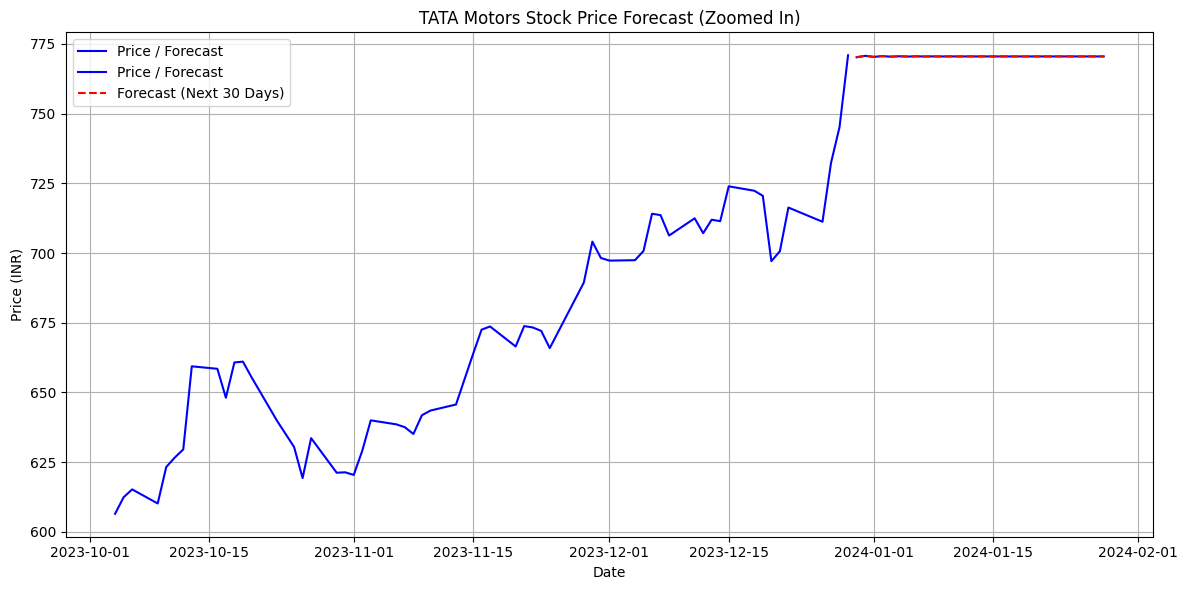

In [21]:
# Combine historical and forecast for zoomed view
combined_df = pd.concat([stock_df['price'], forecast_df['Forecast']])
zoomed_df = combined_df[combined_df.index > '2023-10-01']  # last few months only

plt.figure(figsize=(12,6))
plt.plot(zoomed_df.index, zoomed_df.values, label='Price / Forecast', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (Next 30 Days)', color='red', linestyle='dashed')
plt.title('TATA Motors Stock Price Forecast (Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

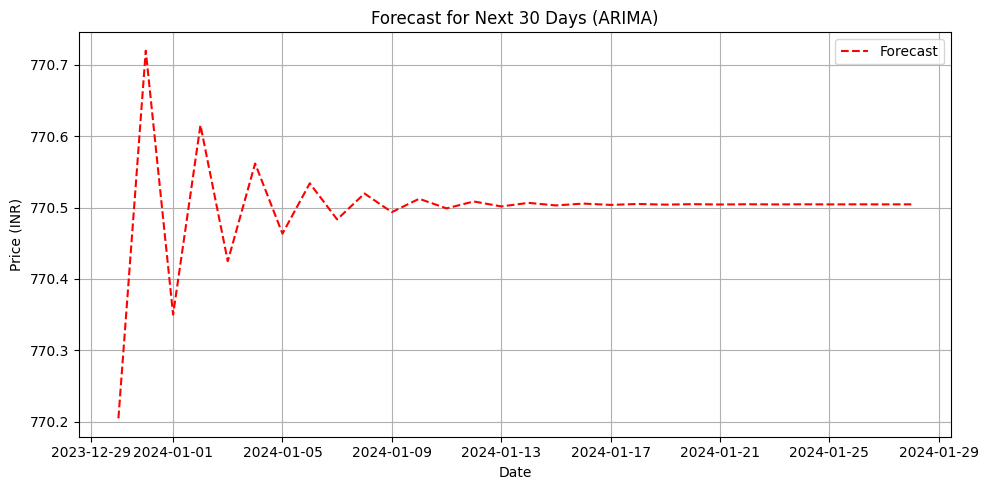

In [22]:
plt.figure(figsize=(10,5))
plt.plot(forecast_df.index, forecast_df['Forecast'], color='red', linestyle='--', label='Forecast')
plt.title("Forecast for Next 30 Days (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SARIMA

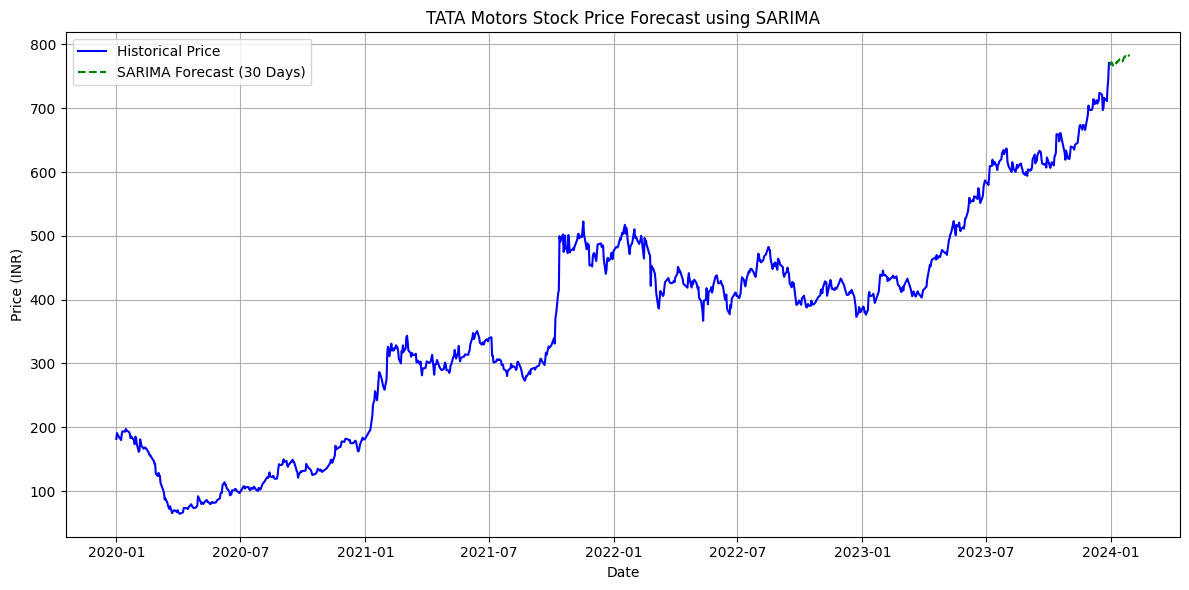

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA: (p,d,q)x(P,D,Q,s) — here trying seasonal cycle of 30 days
model = SARIMAX(stock_df['price'], order=(1,1,1), seasonal_order=(1,1,1,30))
sarima_result = model.fit()

# Forecast next 30 days
forecast_sarima = sarima_result.get_forecast(steps=30)
forecast_index = pd.date_range(start=stock_df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df_sarima = pd.DataFrame(forecast_sarima.predicted_mean.values, index=forecast_index, columns=['Forecast'])

# Plot it
plt.figure(figsize=(12,6))
plt.plot(stock_df.index, stock_df['price'], label='Historical Price', color='blue')
plt.plot(forecast_df_sarima.index, forecast_df_sarima['Forecast'], label='SARIMA Forecast (30 Days)', color='green', linestyle='dashed')
plt.title("TATA Motors Stock Price Forecast using SARIMA")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 last 60–90 days vs forecast, to compare short-term shape vs output.

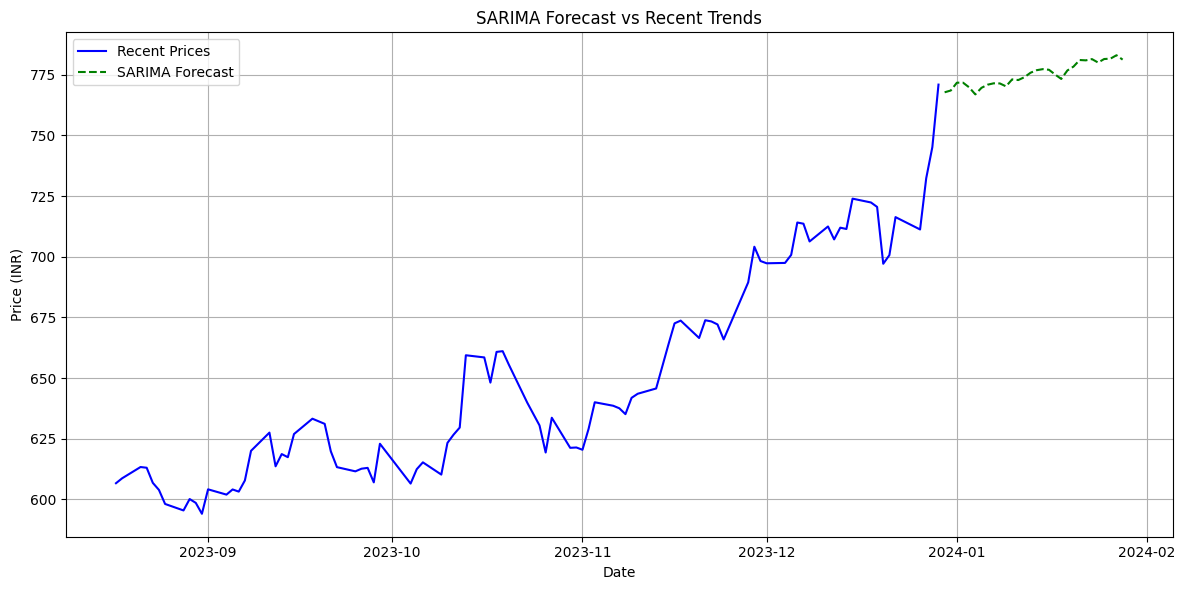

In [24]:
plt.figure(figsize=(12,6))
plt.plot(stock_df.index[-90:], stock_df['price'][-90:], label='Recent Prices', color='blue')
plt.plot(forecast_df_sarima.index, forecast_df_sarima['Forecast'], label='SARIMA Forecast', color='green', linestyle='dashed')
plt.title("SARIMA Forecast vs Recent Trends")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📉 Mean Absolute Error (MAE): 39.88
📉 Mean Squared Error (MSE): 2144.48
📉 Root Mean Squared Error (RMSE): 46.31
📈 R-squared (R²): -2.8711


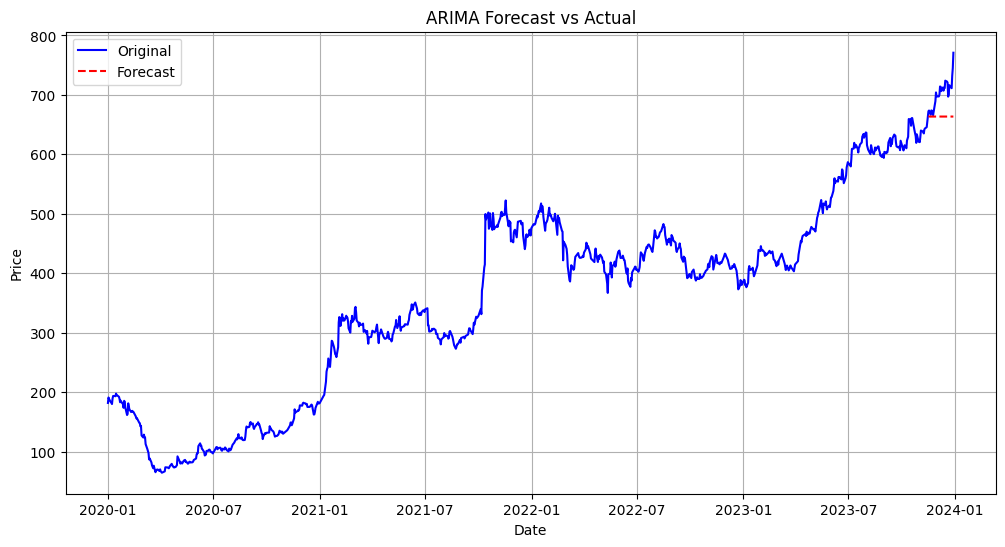

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split into train/test
train = stock_df['price'][:-30]
test = stock_df['price'][-30:]

# Fit ARIMA (using previous best model - ARIMA(1,1,1))
model = ARIMA(train, order=(1,1,1))
results = model.fit()

# Forecast
forecast = results.forecast(steps=30)

# Evaluation Metrics
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

# Print metrics
print(f"📉 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📉 Mean Squared Error (MSE): {mse:.2f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"📈 R-squared (R²): {r2:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(stock_df.index, stock_df['price'], label='Original', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# ARIMA Model Performance Summary

**Evaluation Metrics:**

Mean Absolute Error (MAE): 39.88

Mean Squared Error (MSE): 2144.48

Root Mean Squared Error (RMSE): 46.31

R-squared (R²): -2.8711

**Interpretation of Metrics:**
MAE (39.88) means that, on average, our predictions deviate from actual stock prices by around ₹40. This is moderate in the context of stock prices usually ranging between ₹700–₹800.
RMSE (46.31) further supports this deviation, showing that large errors were penalized more, and confirming volatility in prediction accuracy.
MSE (2144.48), being a squared metric, magnifies larger errors and is used more in comparative modeling than standalone insights.
R-squared (R² = -2.8711) is negative, which occurs when the model performs worse than a simple horizontal mean line. This indicates that the model did not generalize well for the test window — it failed to capture useful structure beyond average behavior.


# Conclusion:
The ARIMA model produced a consistent but smooth forecast, which captured the overall trend but struggled with short-term price volatility. While the predicted values remained within the expected range, the model's accuracy can be improved by incorporating additional techniques or external factors (e.g., news sentiment or technical indicators). Still, this provides a foundational benchmark for time-series forecasting using ARIMA.